In [2]:
#import sklearn
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
# cargar datos
data = pd.read_csv("energy_forecasting.csv")

In [5]:
data.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [6]:
# limpiar base de datos
data_filtered = (
    data
    .assign(
        datetime = lambda k: pd.to_datetime(k.datetime, format="%Y-%m-%d %H:%M:%S"),
        year = lambda k: k.datetime.dt.year,
        month = lambda k: k.datetime.dt.month,
        day = lambda k: k.datetime.dt.day,
        hour = lambda k: k.datetime.dt.hour
    )
    .sort_values(by="datetime")
    .drop(["datetime", "var2", "electricity_consumption", "ID"], axis=1)
    .reset_index()
    .rename({"index":"ID"}, axis=1)
)

In [7]:
data_filtered.head(3)

,ID,temperature,var1,pressure,windspeed,year,month,day,hour
0,0,-11.4,-17.1,1003.0,571.910,2013,7,1,0
1,1,-12.1,-19.3,996.0,575.040,2013,7,1,1
2,2,-12.9,-20.0,1000.0,578.435,2013,7,1,2


In [13]:
# varianza y media de las variables
(
    data_filtered
    .describe().T
    [["mean", "std"]]
    .assign(var = lambda k: round(k["std"]**2, 2))
    .drop("std", axis=1)
)

,mean,var
ID,13247.500000,58505376.00
temperature,5.098989,75.39
var1,-1.916233,108.68
pressure,986.450615,144.06
windspeed,23.959956,2330.99
year,2015.000000,1.50
month,6.500000,11.92
day,12.000000,44.00
hour,11.500000,47.92


In [15]:
# Correlación entre las variables
data_filtered.corr().round(7)

,ID,temperature,var1,pressure,windspeed,year,month,day,hour
ID,1.000000,0.073371,0.055120,-0.010894,-0.081506,0.972272,-0.127178,0.020814,0.000905
temperature,0.073371,1.000000,0.811422,-0.723939,-0.162093,0.112785,-0.185422,-0.009646,0.154194
var1,0.055120,0.811422,1.000000,-0.680821,-0.292305,0.125141,-0.313373,0.023009,-0.021886
pressure,-0.010894,-0.723939,-0.680821,1.000000,0.171369,-0.021243,0.044578,0.027013,-0.033808
windspeed,-0.081506,-0.162093,-0.292305,0.171369,1.000000,-0.094636,0.077188,-0.019587,0.054145
year,0.972272,0.112785,0.125141,-0.021243,-0.094636,1.000000,-0.354787,-0.000000,0.000000
month,-0.127178,-0.185422,-0.313373,0.044578,0.077188,-0.354787,1.000000,0.000000,0.000000
day,0.020814,-0.009646,0.023009,0.027013,-0.019587,-0.000000,0.000000,1.000000,-0.000000
hour,0.000905,0.154194,-0.021886,-0.033808,0.054145,0.000000,0.000000,-0.000000,1.000000


In [92]:
# Forma gráfica (pocas variables)
# plt.figure()
# sns.pairplot(data_filtered)
# plt.show()

In [16]:
#Estandarización
scaler=StandardScaler()
scaler.fit(data_filtered)
scaled_data=pd.DataFrame(
    scaler.transform(data_filtered),
    columns=data_filtered.columns
)

In [18]:
pca=PCA()
#pca=PCA(n_components=10)
pca.fit(scaled_data)

pca_score=pd.DataFrame(data=pca.components_, columns=scaled_data.columns,)

In [19]:
# Ponderación de los componentes principales (vectores propios)
pca_score.apply(lambda k: round(k.abs(), 7))

,ID,temperature,var1,pressure,windspeed,year,month,day,hour
0,0.219097,0.521942,0.534511,0.462715,0.219676,0.264033,0.244990,0.002099,0.042083
1,0.626570,0.219967,0.198256,0.275539,0.012480,0.635883,0.193590,0.018220,0.038539
2,0.072879,0.165911,0.092850,0.058491,0.490141,0.052507,0.082293,0.194804,0.816948
3,0.011842,0.018779,0.003863,0.034738,0.023338,0.018383,0.044013,0.968497,0.239748
4,0.287849,0.035171,0.089803,0.210118,0.299196,0.066541,0.875938,0.046476,0.017841
5,0.110735,0.124368,0.059374,0.222422,0.779868,0.057231,0.191003,0.139414,0.501882
6,0.025043,0.393833,0.422497,0.780098,0.052200,0.028522,0.225217,0.037366,0.039427
7,0.032642,0.692462,0.690118,0.056315,0.101818,0.006539,0.104631,0.023189,0.134544
8,0.676123,0.000000,0.000000,0.000000,0.000000,0.717137,0.168443,0.014073,0.000612


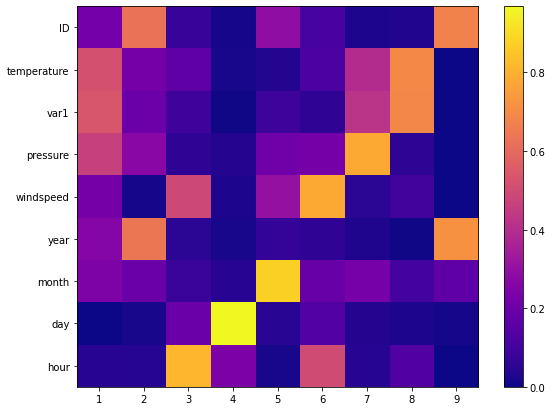

In [157]:
# Mapa de calor para visualizar in influencia de las variables
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
componentes = pca.components_
plt.imshow(abs(componentes.T), cmap='plasma', aspect='auto')
plt.yticks(range(len(scaled_data.columns)), scaled_data.columns)
plt.xticks(range(len(scaled_data.columns)), np.arange(pca.n_components_)+ 1)
plt.grid(False)
plt.colorbar();

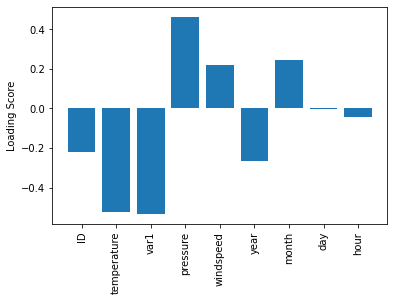

In [158]:
# Aporte al primer componente principal 
matrix_transform = pca.components_.T
plt.bar(np.arange(9),matrix_transform[:,0])
plt.xticks(range(len(scaled_data.columns)), scaled_data.columns,rotation = 90)
plt.ylabel('Loading Score')
plt.show()

In [ ]:
# Variables temporales con menor relevancia con respecto a la varianza.
# Parece ser que la periodicidad de las variables de año y mes son más relevantes
# por su variacion. Revisar

In [159]:
# Pesos
loading_scores = pd.DataFrame(pca.components_[0])
#Nombre de las columnas
loading_scores.index=scaled_data.columns
# Ordena de mayor a menor los pesos
sorted_loading_scores = loading_scores[0].abs().sort_values(ascending=False)
#Selección de las 4 variables que más aportan a cada componente principal
top_4_variables= sorted_loading_scores[:4].index.values
print(top_4_variables)

['var1' 'temperature' 'pressure' 'year']


In [123]:
# Nuevas variables,components principales
pca_data=pca.transform(scaled_data) 
# Forma manual de obtener los componentes princiaples
# pcas = np.dot(pca.components_, scaled_data.T)
# pcas = pd.DataFrame(pcas)
# pcas = pcas.transpose()
pd.DataFrame(pca_data)

,0,1,2,3,4,5,6,7,8
0,5.821075,0.889520,4.067987,2.246780,4.054395,8.566683,-0.467617,-1.151460,-1.521867e-15
1,5.714228,0.995322,4.258123,2.236245,3.932517,8.651916,0.110570,-1.120531,-1.535368e-15
2,5.961756,0.874523,4.382073,2.193663,4.018177,8.544696,-0.082731,-1.145825,-1.548733e-15
3,5.542887,1.086875,4.569381,2.171183,3.972624,8.669822,0.057884,-1.269821,-1.562098e-15
4,6.053390,0.819912,4.699084,2.110363,4.151032,8.464425,-0.501557,-1.105179,-1.575599e-15
...,...,...,...,...,...,...,...,...,...
26491,1.119835,-3.060343,0.939411,-1.884411,0.054908,-0.182663,-0.561757,0.291639,1.586007e-15
26492,0.927294,-2.951442,1.047703,-1.901910,0.049583,-0.120637,-0.346978,-0.169668,1.572506e-15
26493,0.545934,-2.708249,1.308973,-1.907793,-0.115053,0.088643,0.295831,-0.028002,1.559141e-15
26494,0.618641,-2.736728,1.440359,-1.939766,-0.044384,0.080549,0.237356,-0.274196,1.545776e-15


In [20]:
#Porcentaje de varianza explicada por cada componente principal proporciona
per_var=np.round(pca.explained_variance_ratio_*100, decimals=1)
print("# Porcentaje de varianza acumulado de los componentes")
porcent_acum = np.cumsum(per_var) 
porcent_acum

# Porcentaje de varianza acumulado de los componentes


array([ 30.3,  52.3,  64.2,  75.3,  85.5,  95.1,  98.3, 100. , 100. ])

In [ ]:
# To be continued ...